In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models, losses

In [2]:
image_data = tf.keras.datasets.fashion_mnist


In [3]:
(train_img, train_labels), (test_img, test_labels) = image_data.load_data()

<Figure size 800x480 with 0 Axes>

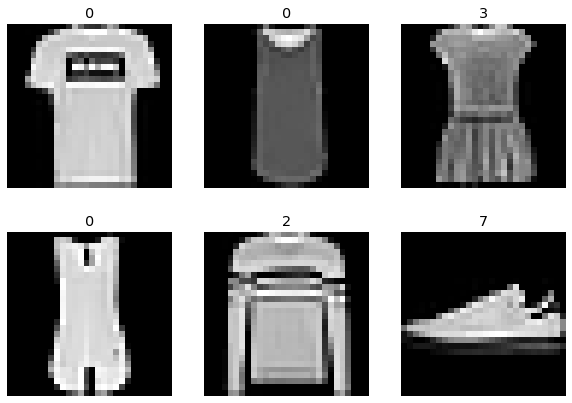

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10, 6), dpi=80)
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 3

for i in range(1, 7):
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_img[i], cmap="gray")
    plt.axis('off')
    plt.title(train_labels[i])

In [5]:
# train_img_flattened = train_img.reshape(len(train_img), 28*28)
# test_img_flattened = test_img.reshape(len(test_img), 28*28)
# not neccesary

In [6]:
train_img_padded = tf.pad(train_img, [[0, 0], [2,2], [2,2]])/255
test_img_padded = tf.pad(test_img, [[0, 0], [2,2], [2,2]])/255
train_img_padded = tf.expand_dims(train_img_padded, axis=3, name=None)
test_img_padded = tf.expand_dims(test_img_padded, axis=3, name=None)


In [7]:
train_img = tf.expand_dims(train_img, axis=3, name=None)
test_img = tf.expand_dims(test_img, axis=3, name=None)

Text(0.5, 1.0, 'With padding(32, 32, 1)')

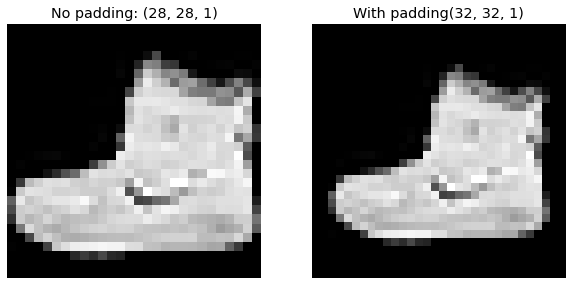

In [8]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 2, 1)
plt.imshow(train_img[0], cmap="gray")
plt.axis('off')
plt.title("No padding: " + str(train_img[0].shape))

fig.add_subplot(1, 2, 2)
plt.imshow(train_img_padded[0], cmap="gray")
plt.axis('off')
plt.title("With padding" + str(train_img_padded[0].shape))

In [27]:
# 1 classic - LeNet
lenet = models.Sequential()
lenet.add(layers.Conv2D(6, 5, activation='tanh', input_shape=train_img_padded.shape[1:]))
lenet.add(layers.AveragePooling2D(2))
lenet.add(layers.Activation('sigmoid'))
lenet.add(layers.Conv2D(16, 5, activation='tanh'))
lenet.add(layers.AveragePooling2D(2))
lenet.add(layers.Activation('sigmoid'))
lenet.add(layers.Conv2D(120, 5, activation='tanh'))
lenet.add(layers.Flatten())
lenet.add(layers.Dense(84, activation='tanh'))
lenet.add(layers.Dense(10, activation='softmax'))
lenet.summary()

lenet_runtime = []

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 activation_2 (Activation)   (None, 14, 14, 6)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 activation_3 (Activation)   (None, 5, 5, 16)         

In [36]:
# 2 own model
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation="relu",input_shape=train_img_padded.shape[1:]))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))
model.summary()

model_runtimes = []

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 6, 6, 64)         

In [35]:
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        self.epochs = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = tf.timestamp()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append(tf.timestamp() - self.timetaken)
        self.epochs.append(epoch)
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(self.epochs, self.times, 'ro')
        total = 0
        for i in range(len(self.epochs)):
          j = self.times[i].numpy()
          if i == 0:
            plt.text(i, j, str(round(j, 3)))
            total += tf.get_static_value(j)
            model_runtimes.append(tf.get_static_value(j))
          else:
            j_prev = self.times[i-1].numpy()
            plt.text(i, j, str(round(j-j_prev, 3)))
            total += tf.get_static_value(j-j_prev)
            model_runtimes.append(tf.get_static_value(j-j_prev))
        plt.savefig(datetime.now().strftime("%Y%m%d%H%M%S") + ".png")
        plt.title(str(round(total, 4)) + "s")

LeNet classification

Epoch 1/10
750/750 [==============================] - 17s 23ms/step - loss: 1.1027 - accuracy: 0.5777 - val_loss: 0.7175 - val_accuracy: 0.7368

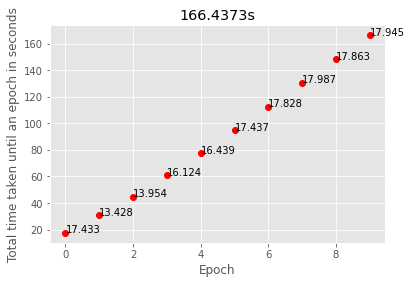

In [28]:
lenet.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
lenet_history = lenet.fit(train_img_padded, train_labels, validation_split = 0.2, batch_size=64, epochs=10, callbacks=[timecallback()])

In [13]:
start = tf.timestamp()
lenet_eval = lenet.evaluate(test_img_padded, test_labels, batch_size=64)
print("Seconds taken for testing: ")
print(tf.get_static_value(tf.timestamp() - start))
print("Accuracy for testing:")
print(str(round(lenet_eval[1] * 100,2)) + "%")

157/157 [==============================] - 1s 6ms/step - loss: 0.4574 - accuracy: 0.8279

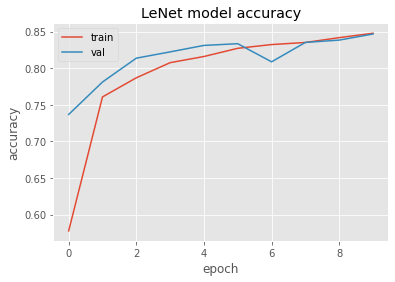

In [29]:
plt.plot(lenet_history.history['accuracy'])
plt.plot(lenet_history.history['val_accuracy'])
plt.title('LeNet model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

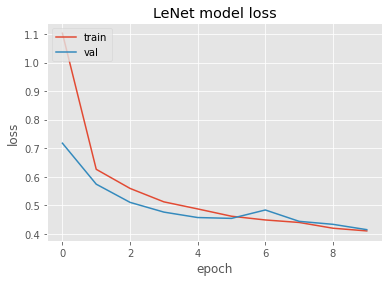

In [30]:
plt.plot(lenet_history.history['loss'])
plt.plot(lenet_history.history['val_loss'])
plt.title('LeNet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Own model classification


In [37]:
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

Epoch 1/10
750/750 [==============================] - 39s 52ms/step - loss: 0.5137 - accuracy: 0.8139 - val_loss: 0.3536 - val_accuracy: 0.8773

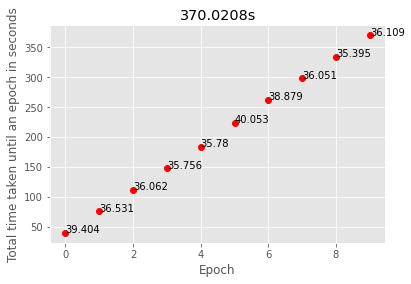

In [38]:
model_train_history = model.fit(train_img_padded, train_labels, validation_split = 0.2, batch_size=64, epochs=10, callbacks=[timecallback()])

In [39]:
start = tf.timestamp()
model_eval = model.evaluate(test_img_padded, test_labels, batch_size=64)
print("Seconds taken for testing: ")
print(tf.get_static_value(tf.timestamp() - start))
print("Accuracy for testing:")
print(str(round(model_eval[1] * 100,2)) + "%")

157/157 [==============================] - 2s 13ms/step - loss: 0.2371 - accuracy: 0.9138

In [19]:
train_img_padded = tf.image.grayscale_to_rgb(train_img_padded)
test_img_padded = tf.image.grayscale_to_rgb(test_img_padded)

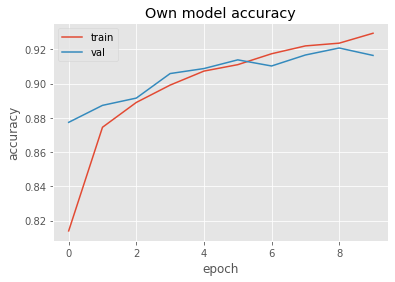

In [41]:
plt.plot(model_train_history.history['accuracy'])
plt.plot(model_train_history.history['val_accuracy'])
plt.title('Own model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

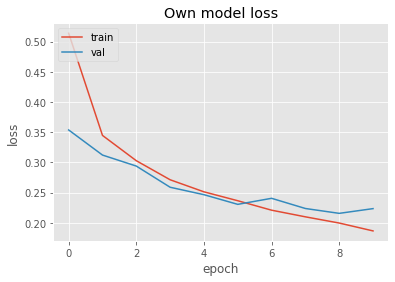

In [42]:
plt.plot(model_train_history.history['loss'])
plt.plot(model_train_history.history['val_loss'])
plt.title('Own model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

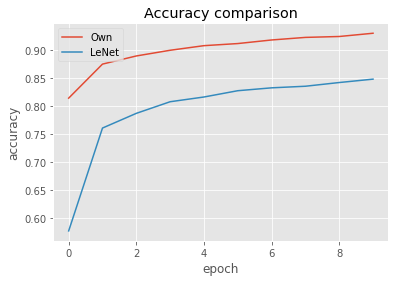

In [43]:
plt.plot(model_train_history.history['accuracy'])
plt.plot(lenet_history.history['accuracy'])
plt.title('Accuracy comparison')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Own', 'LeNet'], loc='upper left')
plt.show()

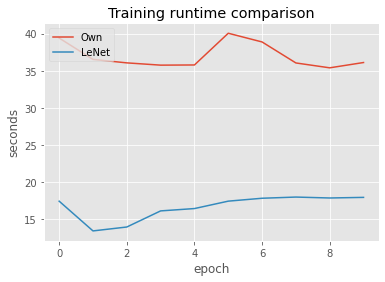

In [44]:
plt.plot(model_runtimes)
plt.plot(lenet_runtime)
plt.title('Training runtime comparison')
plt.ylabel('seconds')
plt.xlabel('epoch')
plt.legend(['Own', 'LeNet'], loc='upper left')
plt.show()


In [46]:
import pandas as pd
import seaborn as sns

testing = pd.DataFrame(columns=["model", "runtime"])
testing = testing.append(pd.DataFrame([{"model": "own", "runtime": 2.0769171714782715}], index=['1'],columns=testing.columns))
testing = testing.append(pd.DataFrame([{"model": "lenet", "runtime": 0.9895520210266113}], index=['1'],columns=testing.columns))

In [48]:
sns.barplot(data=testing, x="model", y="testing runtime")


ValueError: Could not interpret input 'testing runtime'